In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import datetime

plt.rcParams['figure.dpi'] = 300

In [2]:
cifar2d = torch.load('../../data/dlwp/p1ch7/cifar2d.pt')
cifar2l = torch.load('../../data/dlwp/p1ch7/cifar2l.pth')
cifar2d_val = torch.load('../../data/dlwp/p1ch7/cifar2d_val.pt')
cifar2l_val = torch.load('../../data/dlwp/p1ch7/cifar2l_val.pth')

Here we loaded the tensors we saved from the last chapter.

In [3]:
conv = nn.Conv2d(3, 16, kernel_size=3).cuda() #Instead of the shortcut kernel_size=3, we 
                                                            #   could equivalently pass in the tuple that we 
                                                            #   see in the output: kernel_size=(3, 3).
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

This code defines a convolutional layer using the `nn.Conv2d` class from the PyTorch library. The layer has 3 input channels, 16 output channels, and a kernel size of 3x3. The `cuda()` method is called on the layer object to move the layer to the GPU for faster computation.

The comment explains that the `kernel_size` argument can be passed as a tuple instead of using the shortcut notation `kernel_size=3`. In this case, the tuple `(3, 3)` would be equivalent to `kernel_size=3`.

In [4]:
conv.weight.shape, conv.bias.shape  #randomly initialized

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

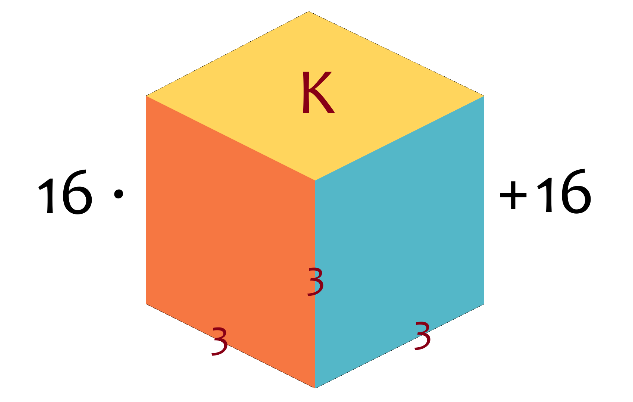

In [5]:
img = cifar2d[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

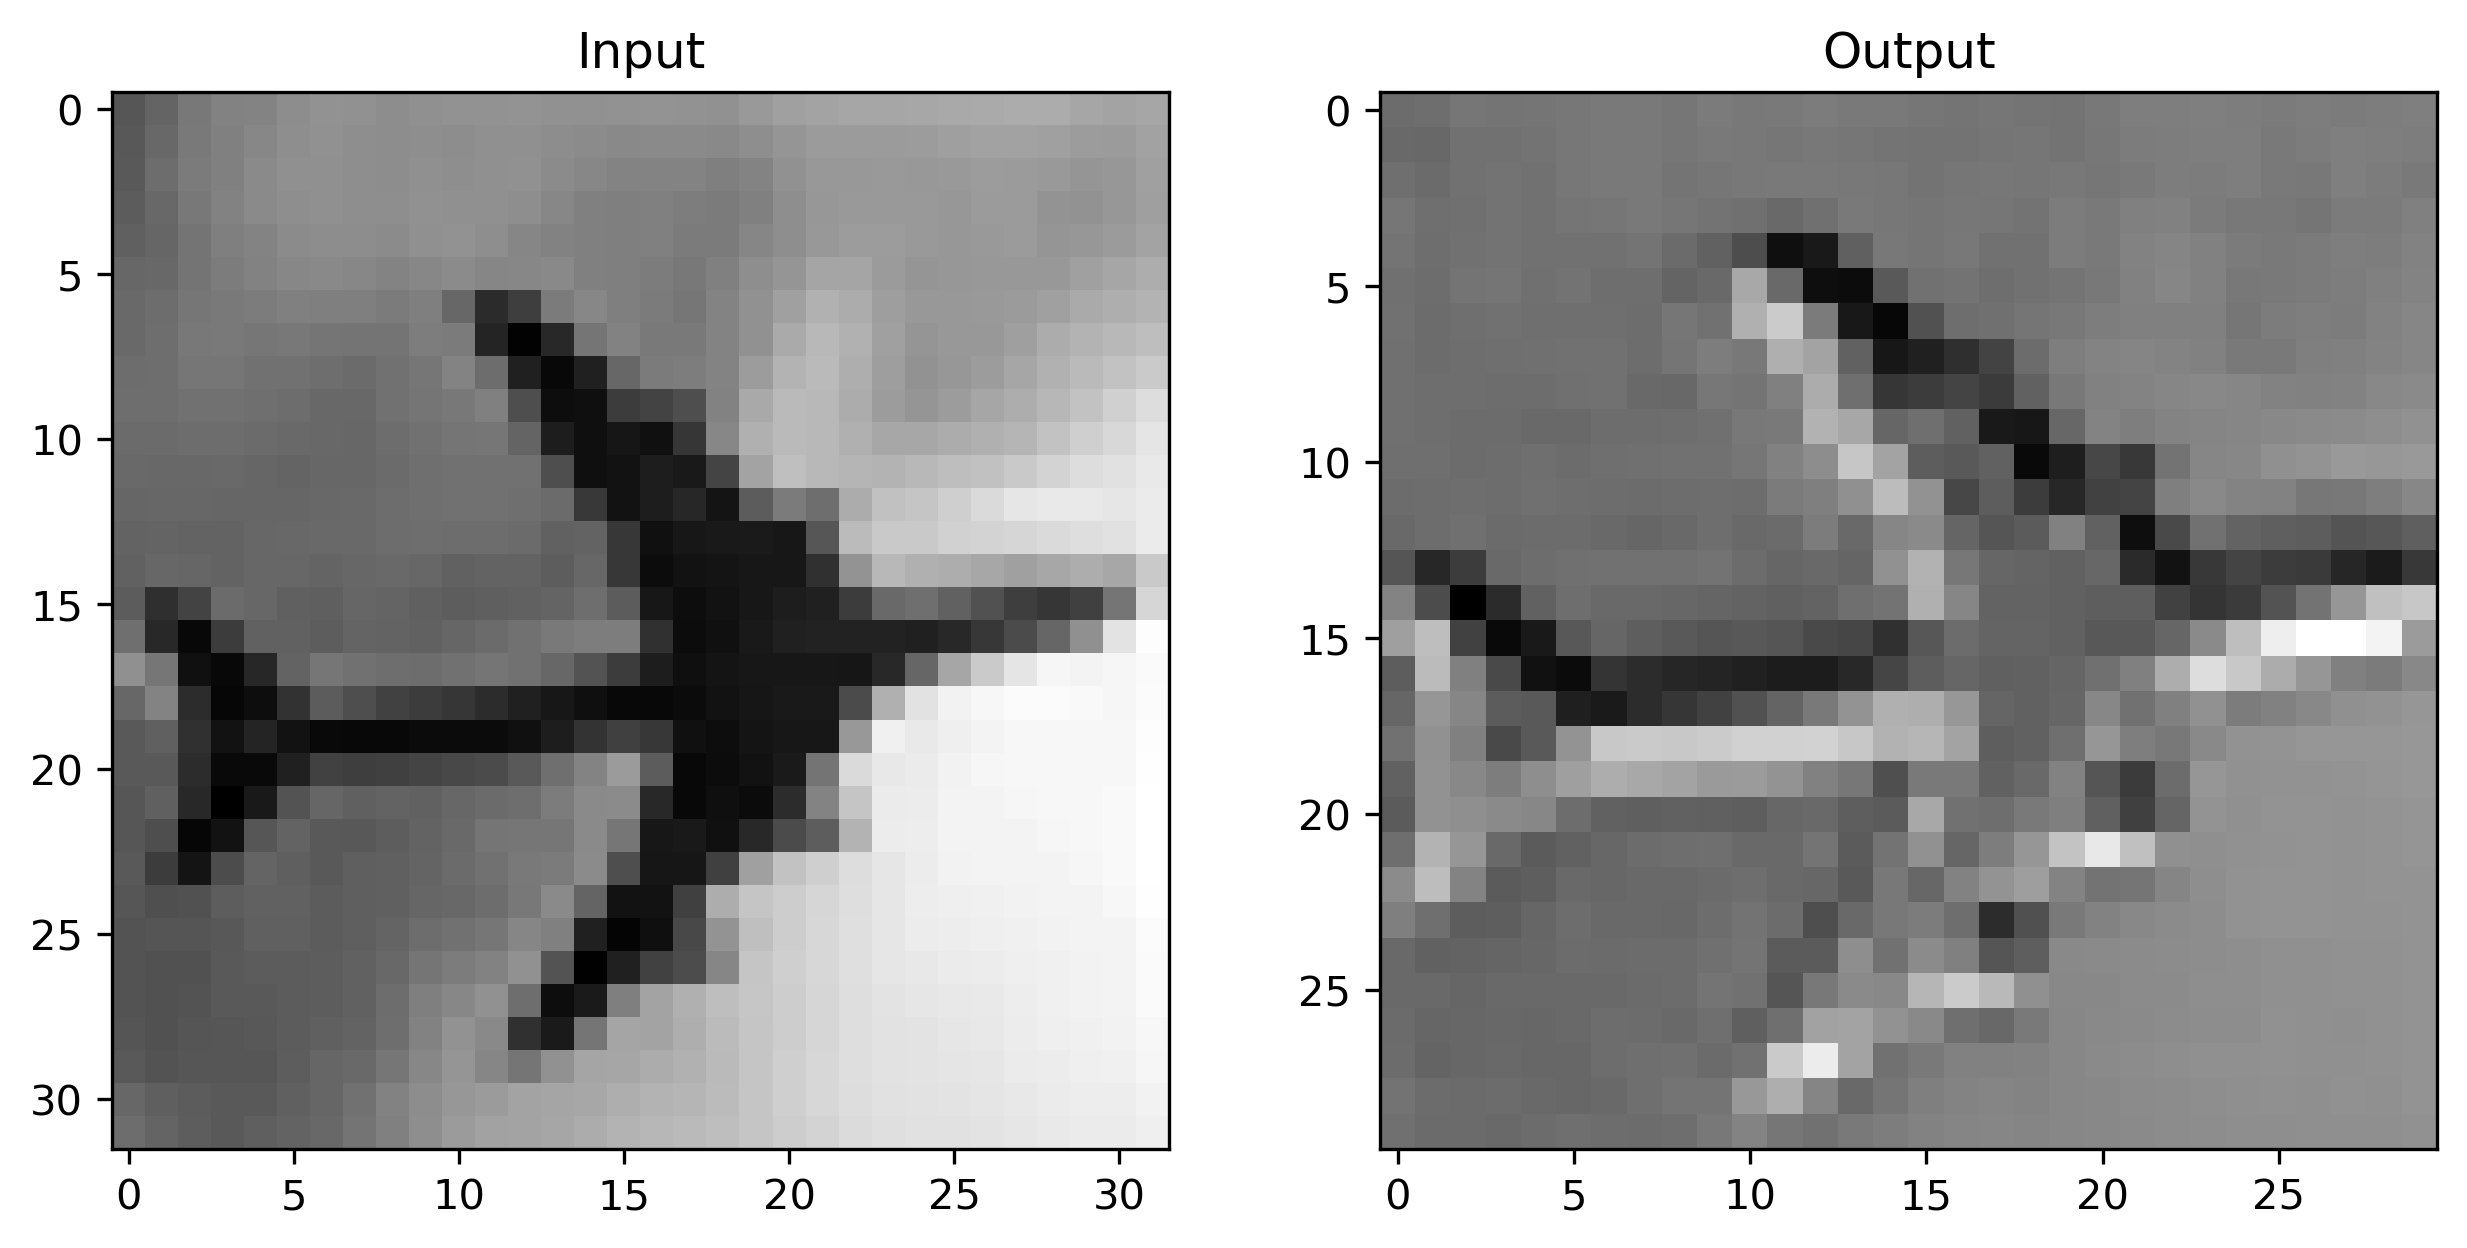

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img[0].detach().cpu(), cmap='gray', label='input')
ax[1].imshow(output[0, 0].detach().cpu(), cmap='gray', label='output')
ax[0].set_title('Input')
ax[1].set_title('Output')
plt.show()

Note that the image's size is reduced due to the kernel applied to it. The kernel is a 3x3 matrix that is applied to the image.

In [7]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


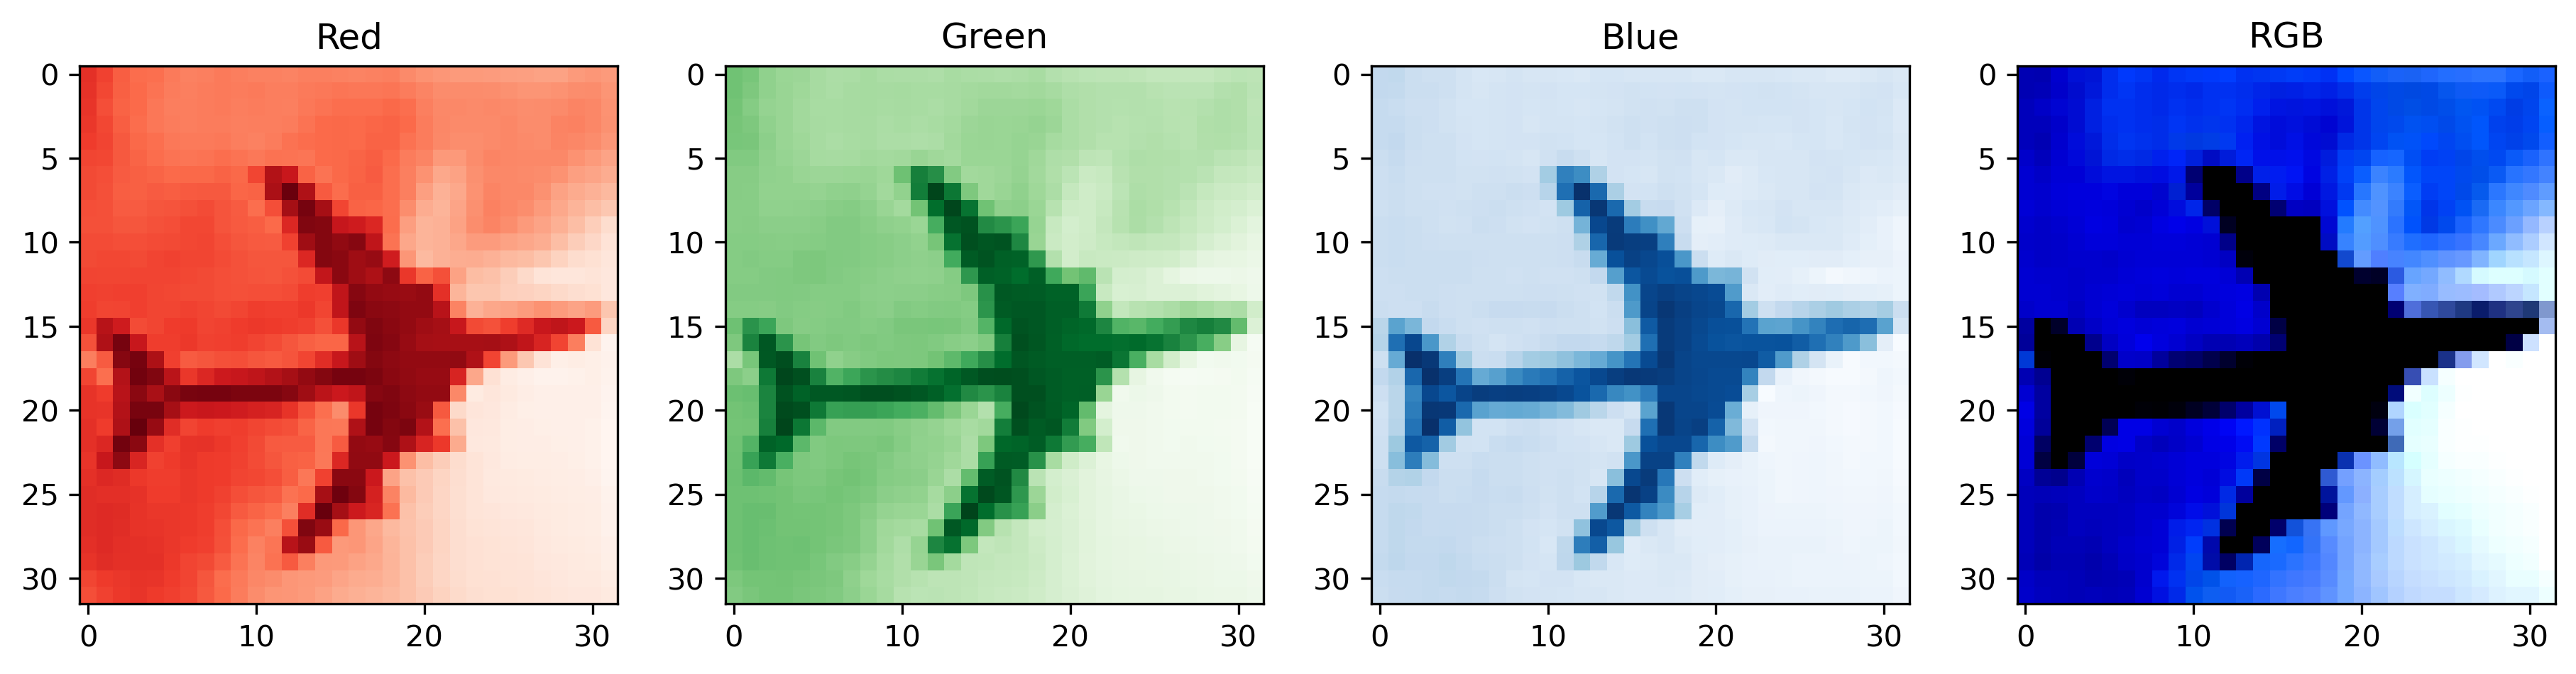

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
rgb = ['Reds_r', 'Greens_r', 'Blues_r']
for i, j in enumerate(img):
    ax[i].imshow(j.detach().cpu(), cmap=rgb[i], label=rgb[i]);
    ax[i].set_title(rgb[i][:-3]);
ax[3].imshow(img.permute(1, 2, 0).cpu().detach());
ax[3].set_title('RGB');

This code creates a figure with four subplots using the `subplots()` function from the Matplotlib library. The figure has a size of 15x5 inches.

The `enumerate()` function is used to iterate over the three color channels of the image `img`. The `detach()` method is called on each channel to remove the tensor from the computational graph, and the `cpu()` method is called to move the tensor to the CPU for display. The `cmap` argument is set to `'Reds_r'`, `'Greens_r'`, and `'Blues_r'` for the red, green, and blue channels, respectively. The `label` argument is set to the same value as `cmap`, but this argument has no effect on the plot. The `set_title()` method is called on each subplot to set its title to the name of the color channel.

The fourth subplot is accessed using `ax[3]` and displays the image `img` in RGB format. The `permute()` method is called on `img` to change the order of the dimensions from `(3, 32, 32)` to `(32, 32, 3)`, which is the format expected by Matplotlib. The `imshow()` function is used to display the image. The `detach()` and `cpu()` methods are called on `img` for the same reasons as with the color channels. The `set_title()` method is called on the subplot to set its title to `'RGB'`.

Finally, the `show()` function is called to display the figure.

In [9]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),     # takes us from 3 RGB channels to 16, thereby giving the network
                                                    #   a chance to generate 16 independent features
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Flatten(),                                   # flatten the tensor from 2D to 1D
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)

)

In [10]:
class Net(nn.Module):   #subclassing nn.Module to create a neural network
    def __init__(self):
        super(Net, self).__init__() #super() function returns a temporary object of the superclass that then allows you to call
                                    # that superclass's methods.
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) #3 input channels, 16 output channels, 3x3 kernel, padding=1
        self.act1 = nn.Tanh()   #!!could be replaced with the functional API: out = F.tanh(out) in the forward pass!!
        self.pool1 = nn.MaxPool2d(2) #2x2 kernel, !!could be replaced with the functional API: out = F.max_pool2d(out, 2) in the forward pass!!
        self.conv2 = nn.Conv2d(16, 8, 3, padding=1) #16 input channels, 8 output channels, 3x3 kernel, padding=1
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2) #2x2 kernel, !!could be replaced with the functional API: out = F.max_pool2d(out, 2) in the forward pass!!
        self.fc1 = nn.Linear(8 * 8 * 8, 32) #8x8x8 input features, 32 output features
        self.act3 = nn.Tanh()   #!!could be replaced with the functional API: out = F.tanh(out) in the forward pass!!
        self.fc2 = nn.Linear(32, 2) #32 input features, 2 output features

    def forward(self, x): #forward pass
        out = self.pool1(self.act1(self.conv1(x))) #conv1 -> act1 -> pool1
        out = self.pool2(self.act2(self.conv2(out))) #conv2 -> act2 -> pool2
        out = out.view(-1, 8 * 8 * 8) #flatten
        out = self.act3(self.fc1(out)) #fc1 -> act3
        out = self.fc2(out) #fc2
        return out

In [11]:
model = Net().cuda()    #using a full modular subclass
model(img.unsqueeze(0))

tensor([[0.0845, 0.0783]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [12]:
#since some of the instances are overkill, we'll use the functional API for a more consice implementation
class Net(nn.Module):   #subclassing nn.Module to create a neural network
    def __init__(self):
        super(Net, self).__init__() #super() function returns a temporary object of the superclass that then allows you to call
                                    # that superclass's methods.
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) #3 input channels, 16 output channels, 3x3 kernel, padding=1
        self.conv2 = nn.Conv2d(16, 8, 3, padding=1) #16 input channels, 8 output channels, 3x3 kernel, padding=1
        self.fc1 = nn.Linear(8 * 8 * 8, 32) #8x8x8 input features, 32 output features
        self.fc2 = nn.Linear(32, 2) #32 input features, 2 output features

    def forward(self, x): #forward pass
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [13]:
# Let's double-check that our model runs, and then we'll get to the training loop:
model = Net().cuda()
model(img.unsqueeze(0))

tensor([[-0.0302, -0.0448]], device='cuda:0', grad_fn=<AddmmBackward0>)

We got two numbers! Information flows correctly. We might not realize it right now,
but in more complex models, getting the size of the first linear layer right is sometimes a source of frustration. We’ve heard stories of famous practitioners putting in
arbitrary numbers and then relying on error messages from PyTorch to backtrack the
correct sizes for their linear layers. Lame, eh? Nah, it’s all legit!

In [14]:
help(torch.utils.data.DataLoader)

Help on class DataLoader in module torch.utils.data.dataloader:

class DataLoader(typing.Generic)
 |  DataLoader(dataset: torch.utils.data.dataset.Dataset[+T_co], batch_size: Optional[int] = 1, shuffle: Optional[bool] = None, sampler: Union[torch.utils.data.sampler.Sampler, Iterable, NoneType] = None, batch_sampler: Union[torch.utils.data.sampler.Sampler[List], Iterable[List], NoneType] = None, num_workers: int = 0, collate_fn: Optional[Callable[[List[~T]], Any]] = None, pin_memory: bool = False, drop_last: bool = False, timeout: float = 0, worker_init_fn: Optional[Callable[[int], NoneType]] = None, multiprocessing_context=None, generator=None, *, prefetch_factor: Optional[int] = None, persistent_workers: bool = False, pin_memory_device: str = '')
 |  
 |  Data loader. Combines a dataset and a sampler, and provides an iterable over
 |  the given dataset.
 |  
 |  The :class:`~torch.utils.data.DataLoader` supports both map-style and
 |  iterable-style datasets with single- or multi-proc

In [15]:
cifar2 = []
for n, i in enumerate(cifar2d):
    cifar2.append((i, cifar2l[n]))

In [16]:
cifar2_val = []
for n, i in enumerate(cifar2d_val):
    cifar2_val.append((i, cifar2l_val[n]))

In [17]:
cifar2[0]

(tensor([[[-0.7991, -0.6404, -0.4181,  ...,  0.1059,  0.0741,  0.1059],
          [-0.7832, -0.5927, -0.4022,  ..., -0.0053, -0.0212,  0.0582],
          [-0.7515, -0.5451, -0.3863,  ..., -0.0847, -0.0688,  0.0424],
          ...,
          [-0.7674, -0.8309, -0.7991,  ...,  0.9315,  0.9473,  1.0108],
          [-0.6086, -0.7039, -0.7356,  ...,  0.9156,  0.9156,  0.9632],
          [-0.5451, -0.6404, -0.7197,  ...,  0.8838,  0.8838,  0.9315]],
 
         [[-0.2736, -0.2091, -0.0159,  ...,  0.4028,  0.3706,  0.3867],
          [-0.2736, -0.1608, -0.0159,  ...,  0.2901,  0.2740,  0.3545],
          [-0.2414, -0.1125,  0.0163,  ...,  0.2418,  0.2740,  0.3867],
          ...,
          [-0.2736, -0.3219, -0.2897,  ...,  1.0148,  1.0309,  1.0954],
          [-0.1769, -0.2414, -0.2414,  ...,  0.9987,  0.9987,  1.0470],
          [-0.1286, -0.1930, -0.2414,  ...,  0.9665,  0.9665,  1.0148]],
 
         [[ 0.7056,  0.6906,  0.8105,  ...,  1.0054,  0.9754,  1.0054],
          [ 0.7056,  0.7205,

In [18]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [19]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(n_epochs):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, torch.tensor(labels).byte())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print(f'{datetime.datetime.now()}, Epoch {epoch}, training loss = {loss_train / len(train_loader)}')

In [20]:
model = Net().cuda()
optimizer = optim.SGD(model.parameters(), lr = 1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(
                n_epochs = 100,
                optimizer = optimizer,
                model = model,
                loss_fn = loss_fn,
                train_loader = train_loader,
            )

/tmp/ipykernel_1015/1953775026.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(outputs, torch.tensor(labels).byte())


2023-08-15 06:42:00.416126, Epoch 0, training loss = 0.588511837993638
2023-08-15 06:42:00.767220, Epoch 1, training loss = 0.49659940297320737
2023-08-15 06:42:04.098312, Epoch 10, training loss = 0.3329552667120756
2023-08-15 06:42:08.010182, Epoch 20, training loss = 0.2967760401257014
2023-08-15 06:42:11.432268, Epoch 30, training loss = 0.2709351878423812
2023-08-15 06:42:15.658374, Epoch 40, training loss = 0.2547173971089266
2023-08-15 06:42:19.548248, Epoch 50, training loss = 0.23062558390073856
2023-08-15 06:42:23.554537, Epoch 60, training loss = 0.21536113858475522
2023-08-15 06:42:28.324615, Epoch 70, training loss = 0.19652337239960493
2023-08-15 06:42:32.178376, Epoch 80, training loss = 0.18355031740867486
2023-08-15 06:42:36.227800, Epoch 90, training loss = 0.16978228338441606


In [21]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                            shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                        shuffle=False)

In [22]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))

In [23]:
validate(model, train_loader, val_loader)

Accuracy train: 0.86
Accuracy val: 0.82


3% difference isn't that much, but we'll practise regularization anyway.

In [24]:
data_path = '../../data/dlwp/p1ch7/'
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

Two ways of generalization techniques are: 
* Regularization
* Dropout
* Batch Normalization

$\rightarrow$ Regularization is a technique that helps to prevent overfitting by adding a penalty term to the loss function. This is implemented in the reaining loop by adding the regularization term to the loss function.

$\rightarrow$ Dropout on the other hand is a technique that randomly drops some neurons during training. This is implemented by adding the dropout layer to the model itself.

$\rightarrow$ Batch Normalization is a technique that normalizes the input layer by adjusting and scaling the activations. This is implemented by adding the batch normalization layer to the model itself.

In [25]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(n_epochs):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, torch.tensor(labels).byte())
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()  #Replaces pow(2.0) with abs() for L1 regularization
                            for p in model.parameters())    #The whole regularization could be done from SGD optimizer
            loss = loss + l2_lambda * l2_norm
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print(f'{datetime.datetime.now()}, Epoch {epoch}, training loss = {loss_train / len(train_loader)}') 

In [26]:
class NetDropout(nn.Module):
    '''
    Note that dropout is normally active during training, while during the evaluation of a
    trained model in production, dropout is bypassed or, equivalently, assigned a probability equal to zero.
    This is controlled through the train property of the Dropout
    module. Recall that PyTorch lets us switch between the two modalities by calling
    `model.train()` or `model.eval()` on any nn.Model subclass.
    The call will be automatically replicated on the submodules so that if Dropout is among them,
    it will behave accordingly in subsequent forward and backward passes.
    '''
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
        padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

This code defines a neural network model using the `nn.Module` class from the PyTorch library. The model is called `NetDropout`.

The `__init__()` method initializes the model's layers. The model has two convolutional layers, two dropout layers, and two fully connected layers. The first convolutional layer has 3 input channels, `n_chans1` output channels, a kernel size of 3x3, and padding of 1 pixel. The second convolutional layer has `n_chans1` input channels, `n_chans1 // 2` output channels, a kernel size of 3x3, and padding of 1 pixel. The two dropout layers have a dropout probability of 0.4. The first fully connected layer has `8 * 8 * n_chans1 // 2` input features and 32 output features. The second fully connected layer has 32 input features and 2 output features.

The `forward()` method defines the forward pass of the model. The input tensor `x` is passed through the first convolutional layer, followed by a max pooling operation and a dropout layer. The resulting tensor is then passed through the second convolutional layer, followed by another max pooling operation and dropout layer. The tensor is then flattened and passed through the first fully connected layer, followed by a hyperbolic tangent activation function. The resulting tensor is then passed through the second fully connected layer to produce the output tensor.

In [27]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super(NetBatchNorm, self).__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                                padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


In [28]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        return torch.relu(self.batch_norm(self.conv(x))) + x

This code defines a residual block for a convolutional neural network using the `nn.Module` class from the PyTorch library. The residual block is called `ResBlock`.

The `__init__()` method initializes the layers of the residual block. The block has a convolutional layer, a batch normalization layer, and an initialization of the weights and biases. The convolutional layer has `n_chans` input and output channels, a kernel size of 3x3, and padding of 1 pixel. The batch normalization layer has `n_chans` feature maps. The weights of the convolutional layer are initialized using the Kaiming normal initialization with a ReLU nonlinearity. The weights of the batch normalization layer are initialized to 0.5, and the biases are initialized to 0.

The `forward()` method defines the forward pass of the residual block. The input tensor `x` is passed through the convolutional layer, followed by the batch normalization layer and a ReLU activation function. The resulting tensor is then added element-wise to the input tensor `x` to produce the output tensor. This is the residual connection that gives the block its name.

In [29]:
class ResNetDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10) -> None:
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

This code defines a deep residual neural network using the `nn.Module` class from the PyTorch library. The model is called `ResNetDeep`.

The `__init__()` method initializes the model's layers. The model has a convolutional layer, a sequence of residual blocks, and two fully connected layers. The convolutional layer has 3 input channels, `n_chans1` output channels, a kernel size of 3x3, and padding of 1 pixel. The sequence of residual blocks is defined using the `nn.Sequential()` function and contains `n_blocks` instances of the `ResBlock` class. The first fully connected layer has `8 * 8 * n_chans1` input features and 32 output features. The second fully connected layer has 32 input features and 2 output features.

In the implementation, we parameterize the actual number of layers, which is important for experimentation and reuse. Also, needless to say, backpropagation will work as
expected.

The `forward()` method defines the forward pass of the model. The input tensor `x` is passed through the convolutional layer, followed by a max pooling operation and a ReLU activation function. The resulting tensor is then passed through the sequence of residual blocks, followed by another max pooling operation. The tensor is then flattened and passed through the first fully connected layer, followed by a ReLU activation function. The resulting tensor is then passed through the second fully connected layer to produce the output tensor.

## 8.5.5 Keeping up with the fast pace of deep learning
One of the challenges and opportunities of being a deep learning practitioner is that neural network architectures are constantly evolving and improving. This means that what we have learned in this chapter is not the final word, but a starting point for exploring more advanced and efficient models. However, it also means that we need to be able to read and understand the latest research papers and implement their ideas in PyTorch code, or at least learn from the code that others have shared online. In the previous chapters, we have hopefully acquired some of the essential skills to translate concepts into working models in PyTorch.

## 8.6 Conclusion
We have accomplished a lot in this chapter. We have built a model that can help Jane find suitable images for her blog. All we need to do is resize and crop the images to 32 x 32 pixels, and feed them to the model. Of course, this is only a partial solution, but it was a rewarding journey.

We still have some challenges to overcome. One is how to locate a bird or an airplane in a larger image. Our model cannot draw bounding boxes around the objects, which is another task that requires a different approach. Another challenge is how to deal with unexpected inputs, such as Fred the cat walking into the frame. Our model will not say "I don't know", but rather assign a high probability to either "airplane" or "bird". This problem of being overconfident about samples that are very different from the training data is called overgeneralization. It is one of the main issues when we deploy a model in real-world scenarios, where we cannot trust the input to be always valid.

In this chapter, we have learned how to use PyTorch to create models that can learn from images. We have gained some intuition about convolutional networks and how they work. We have also explored some techniques to improve our models, such as making them wider and deeper, and adding regularization methods. We have not covered everything, but we have taken a big step forward from the previous chapter. We now have a solid foundation for working on deep learning projects.

In part 2 of this book, we will switch gears and focus on a larger and more complex problem: automatic detection of lung cancer from CT scans. We will use this problem as an example to demonstrate how to apply deep learning in a real-world setting. We will start by describing the problem and the data in the next chapter, and then we will dive into the details of building and training our models.

## 8.7 Exercises
1. Changing the kernel size to 5 × 5 will increase the number of parameters in the model, because each convolutional filter will have more weights to learn.

    * $a$ - This can improve the model's ability to capture more features, but it can also increase the risk of overfitting. You can check the number of parameters in your model by using `torchsummary` or `pytorch_model_summary` packages.

    * $b$ - To see if the change improves or degrades overfitting, you can compare the training and validation losses and accuracies of the model with different kernel sizes. If the gap between the training and validation metrics is large, it means the model is overfitting. You can also use regularization techniques such as dropout or batch normalization to reduce overfitting.
    
    * $c$ - The `kernel_size` argument in `nn.Conv2d` specifies the height and width of the convolutional filters. It can be either a single integer or a tuple of two integers. For example, `kernel_size=5` is equivalent to `kernel_size=(5,5)`, which means a 5 × 5 filter. If you use a tuple, you can specify different heights and widths for the filters, such as `kernel_size=(1,3)`.
    
    * $d$ - Using `kernel_size=(1,3)` will create filters that have one row and three columns. This means that the filters will only convolve along the horizontal direction, and not along the vertical direction. This can be useful for capturing horizontal features in the images, such as edges or lines.
    
    * $e$ - The model's behavior with such a kernel will depend on the data and the task. You can experiment with different kernel sizes and see how they affect the model's performance and output.

2. Finding an image that contains neither a bird nor an airplane, but that the model claims has one or the other with more than 95% confidence, is not easy, but not impossible either. You can try to find images that have similar shapes, colors, or textures as birds or airplanes, such as kites, drones, balloons, feathers, wings, etc. You can also use online tools such as [this one](https://www.fotor.com/images/create) to generate random images and see if any of them fool the model.

    * $a$ - To manually edit a neutral image to make it more airplane-like, you can try to add some features that are characteristic of airplanes, such as wings, propellers, windows, logos, etc. You can use image editing software such as GIMP or Photoshop to do this.

    * $b$ - To manually edit an airplane image to trick the model into reporting a bird, you can try to remove some features that are characteristic of airplanes, such as metal parts, engines, wheels, etc., and add some features that are characteristic of birds, such as feathers, beaks, eyes, etc.

    * $c$ - These tasks may get easier with a network with less capacity, because a network with less capacity has fewer parameters and less ability to learn complex features. A network with more capacity may be more robust and accurate in distinguishing between birds and airplanes.

## 8.8 Summary
This chapter covers the following topics:
- How convolution can be used as a linear operation for image processing in feed-forward networks. Convolution reduces the number of parameters in the network, and takes advantage of the local and translational properties of images.
- How stacking several convolutional layers with activation functions and max pooling layers can create deeper networks that can capture more complex features and spatial relationships in the images.
- How any subclass of nn.Module can recursively access and return the parameters of itself and its children. This technique can be useful for counting, optimizing, or examining the parameters.
- How the functional API provides modules that do not store any internal state. These modules are used for operations that do not have any parameters and do not need to be trained.
- How to save and load the parameters of a trained model with a single line of code.